In [1]:
%matplotlib inline
%gui qt

import os

import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.exposure import rescale_intensity

import utoolbox.utils.files as fileutils
from utoolbox.container import Raster
from utoolbox.io.layouts import Volume
from utoolbox.analysis.roi import extract_mask, mask_to_contour

plt.rcParams['figure.figsize'] = (8, 8)

### Load data

In [2]:
source_folder = os.path.join("data", "20171201_RFiSHp2aLFCYC", "decon", "488")
print(source_folder)
file_list = fileutils.list_files(
    source_folder, 
    name_filters=[fileutils.ExtensionFilter('tif')]
)

#DEBUG bypass
file_path = file_list[1]
print(file_path)

data/20171201_RFiSHp2aLFCYC/decon/488
data/20171201_RFiSHp2aLFCYC/decon/488/cell4_ch0_stack0001_488nm_0010060msec_0007944791msecAbs_decon.tif


In [3]:
I = Raster(Volume, file_path)

In [41]:
from scipy.ndimage.interpolation import zoom
I = zoom(I, [1., .102/.3, .102/.3])

Preview

shape=(140, 275, 275)
dtype=float32


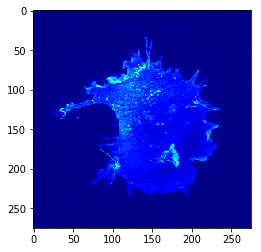

In [42]:
print("shape={}".format(I.shape))
print("dtype={}".format(I.dtype))

Ixy = np.amax(I, axis=0)

plt.figure()
plt.imshow(Ixy, cmap='jet')

### Pre-process

Rescale to [0., 1.]

In [43]:
I = rescale_intensity(I, out_range=(0., 1.))

Obtain log spectrum

In [52]:
FI = np.fft.fftn(I)

In [53]:
AI = np.abs(FI)
PI = np.angle(FI)

In [54]:
AIlog = np.log(AI)

In [55]:
from scipy.ndimage.filters import gaussian_filter
AIs = gaussian_filter(AIlog, sigma=3)

In [56]:
S = np.exp(AIs + 1j * PI)
S = np.real(np.fft.ifftn(S)**2)

In [57]:
S = gaussian_filter(S, sigma=3)

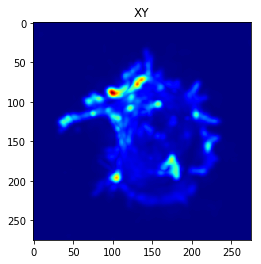

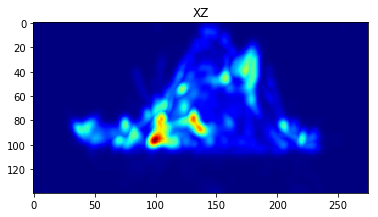

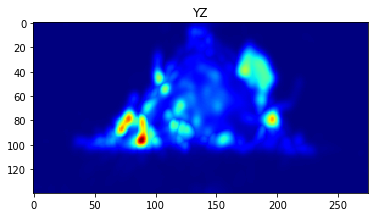

In [58]:
Itmp = np.copy(S)

plt.figure()
plt.title('XY')
plt.imshow(np.amax(Itmp, axis=0), cmap='jet')

plt.figure()
plt.title('XZ')
plt.imshow(np.amax(Itmp, axis=1), cmap='jet')

plt.figure()
plt.title('YZ')
plt.imshow(np.amax(Itmp, axis=2), cmap='jet')

### Create seeds

In [90]:
m = np.mean(S)
s = np.std(S)

T_fg = m + 2*s
T_bg = m + s

In [91]:
print("foreground={:.5f}, background={:.5f}".format(T_fg, T_bg))

foreground=0.00078, background=0.00043


In [142]:
F_1 = np.copy(I)
F_1[S <= T_fg] = 0

B_1 = np.copy(I)
B_1[S >= T_bg] = B_1.max()

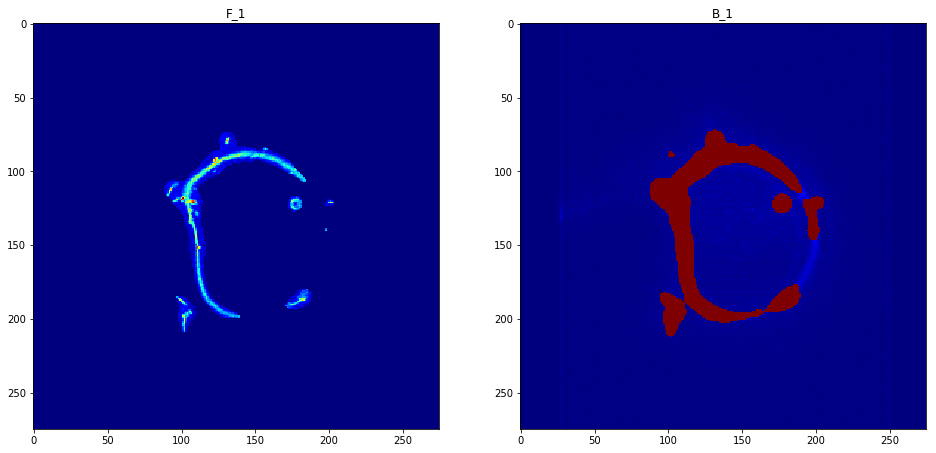

In [143]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('F_1')
plt.imshow(F_1[70, ...], cmap='jet')

plt.subplot(122)
plt.title('B_1')
plt.imshow(B_1[70, ...], cmap='jet')

In [145]:
T_fg2 = np.mean(F_1[F_1 > 0])

m = np.mean(B_1[B_1 > 0])
s = np.std(B_1[B_1 < B_1.max()])
T_bg2 = m + 2*s

In [146]:
print("foreground={:.5f}, background={:.5f}".format(T_fg2, T_bg2))

foreground=0.08921, background=0.07203


In [147]:
F_2 = F_1 > T_fg2
B_2 = B_1 < T_bg2

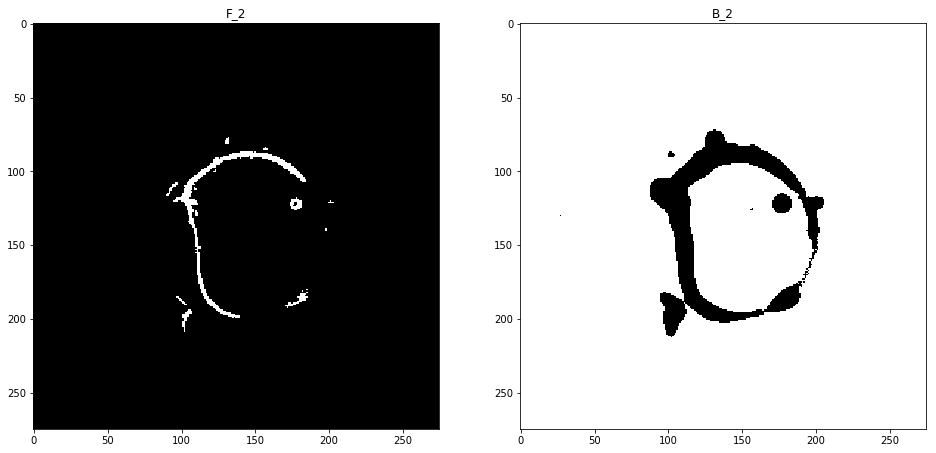

In [148]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('F_2')
plt.imshow(F_2[70, ...], cmap='gray')

plt.subplot(122)
plt.title('B_2')
plt.imshow(B_2[70, ...], cmap='gray')

In [151]:
imageio.volwrite("data/foreground.tif", F_2.astype(np.uint8) * 255)
imageio.volwrite("data/background.tif", B_2.astype(np.uint8) * 255)
imageio.volwrite("data/downsample.tif", (I * 255).astype(np.uint8) )